In [2]:
import numpy as np
from scipy.linalg.interpolative import interp_decomp
import matplotlib.pyplot as plt

In [4]:
# Use scipy's implementation of the interpolative decomposition
# Instead of the matrix cross interpolation M = C @ P^-1 @ R
# it factorizes as M = A @ P with A = M[:, idx]
def interpolative_decomposition(M, eps_or_k=1e-5, k_min=2):
    r = min(M.shape)
    if r <= k_min:
        k = r
        idx, proj = interp_decomp(M, eps_or_k=k) #eps_or_k = precision of decomposition
    elif isinstance(eps_or_k, int): #checks if eps is an integer
        k = min(r, eps_or_k)
        idx, proj = interp_decomp(M, eps_or_k=k)
    else:
        k, idx,  proj = interp_decomp(M, eps_or_k=eps_or_k)
        if k <= k_min:
            k = min(r, k_min) #is it not enough to put k = k_min? 
                              #r>k_min otherwise first condition would have been true
            idx, proj = interp_decomp(M, eps_or_k=k)
    A = M[:, idx[:k]]
    P = np.concatenate([np.eye(k), proj], axis=1)[:, np.argsort(idx)]
    return A, P, k, idx[:k]

# k is the 'compressed' rank = number of pivot columns
# idx is the array with entries the indeces of the pivot columns
# proj = matrix R s.t. M[:,idx[:k]]*R = M[:,idx[k:]] 
# P = matrix s.t.  M[:,idx[:k]]*P = M (approximated)

In [ ]:
class func:  #sin(x) with x given as binary


    def __call__(self, *args, **kwds):
        
        if args in self.cache:
            return self.cache[*args]
        else:
            val=func(*args)
            self.cache[*args] = val
            return val
        
    def __init__(self):
        self.cache = {}



In [ ]:
# implement the tensor cross interpolation
def tensor_cross_interpolation(tensor, L, d=2, eps_or_chi=1e-6, iters=6):
    # random initial choice for index sets
    idxs = np.random.choice(d, size=(L)) #array of L random numbers from 0 to d-1 - index sigma
    As = [np.array([[[tensor(*idxs[:j], i, *idxs[j+1:])] for i in range(d)]])
          for j in range(L)]
    As[1:] /= tensor(*idxs)
    #this sort of corresponds to inserting the P^-1 0-dimensional slices
    #i.e. if I don't put this, evaluating F(σ1,...,σL)= As*...*As = F(σ1,..,σL)^L, when it should give just F!

    I = [idxs[:j].reshape(1, -1) for j in range(L)] # creates list of I_l arrays
    J = [idxs[j:].reshape(1, -1) for j in range(1, L+1)] # list of J_l
    eval1 = 0
    eval2 = 0
    finaleval = 0
    # sweep
    for i in range(iters):
        #print(f'Sweep: {i+1:d}.')
        As, I, eval1 = left_to_right_sweep(tensor, As, I, J, L, d, eps_or_chi)
        As, J, eval2 = right_to_left_sweep(tensor, As, I, J, L, d, eps_or_chi)
        finaleval = finaleval + eval1 + eval2
    return As, J, finaleval

def left_to_right_sweep(tensor, As, I, J, L, d, eps_or_chi):
    # sweep left to right
    eval = 0
    for bond in range(L-1):
        # construct local two-site tensor
        chil, _ = I[bond].shape #chil = number of rows in array I_l: number of combinations (σ1,..,σl)
        chir, _ = J[bond+1].shape #which corresponds to number of "points" on which I am evaluating function

        Pi = np.zeros(chil, d, d, chir)
        for il in range(chil):
            for s1 in range(d):
                for s2 in range(d):
                    for jr in range(chir):
                        val = func(*I[bond][il,:],s1,s2,*J[bond][jr,:])
                        Pi[il,s1,s2,jr] = val
        """Pi = tensor(*I[bond].T[:, :, None, None, None],
                    np.arange(d)[None, :, None, None],
                    np.arange(d)[None, None, :, None],
                    *J[bond+1].T[:, None, None, None, :])\
            .reshape(chil * d, d * chir) #why this structure with square brackets?"""
        # decompose using interpolative decomposition:
        # Pi = P^T @ A^T, A^T = Pi[idx,:]
        A, P, k, idx = interpolative_decomposition(Pi.T, eps_or_k=eps_or_chi)
        eval += d*d*chil*chir
        # update indices using idxs c I[bond] x {0, 1, ..., d-1}
        I[bond+1] = np.array([np.append(I[bond][i//d], [i%d]) for i in idx])
        # update tensors
        As[bond] = P.T.reshape(chil, d, k)
        As[bond+1] = A.T.reshape(k, d, chir)



    return As, I, eval

def right_to_left_sweep(tensor, As, I, J, L, d, eps_or_chi):
    # sweep right to left
    eval = 0
    for bond in range(L-2,-1,-1):
        # construct local two-site tensor
        chil, _ = I[bond].shape
        chir, _ = J[bond+1].shape
        Pi = tensor(*I[bond].T[:, :, None, None, None],
                    np.arange(d)[None, :, None, None],
                    np.arange(d)[None, None, :, None],
                    *J[bond+1].T[:, None, None, None, :])\
            .reshape(chil * d, d * chir)
        # decompose using interpolative decomposition:
        # Pi = A @ P, A = Pi[:,idx]
        A, P, k, idx = interpolative_decomposition(Pi, eps_or_k=eps_or_chi)
        eval+= d*d*chil*chir
        # update indices using idxs c {0, 1, ..., d-1} x J[bond+1]
        J[bond] = np.array([np.append([i//chir], J[bond+1][i%chir]) for i in idx])
        # update tensors
        As[bond] = A.reshape(chil, d, k)
        As[bond+1] = P.reshape(k, d, chir)
    return As, J, eval

In [6]:
#TEST:
L = 5

idxs = np.random.choice(d, size=(L)) #array of L random numbers from 0 to d-1 - index sigma

I = [idxs[:j].reshape(1, -1) for j in range(L)] # creates list of I_l arrays
J = [idxs[j:].reshape(1, -1) for j in range(1, L+1)] # list of J_l

print(I)
print()
print(J)

bond = 3
chil, _ = I[bond].shape #chil = number of terms in array I_l
chir, _ = J[bond+1].shape

print(chil)


NameError: name 'd' is not defined

In [7]:
def eval_error(test_func, xs, maxiter):
    func_vals = test_func(xs)
    func = lambda *args: func_vals.reshape((2,)*10)[*args]
    evals = []
    err_max = []
    err_2 = []
    As = []
    for iters in range(1,maxiter+1):
        As.append(tensor_cross_interpolation(func, L = 10, eps_or_chi=10, iters=iters)[0])
        evals.append(tensor_cross_interpolation(func, L = 10, eps_or_chi=10, iters=iters)[2])
    for i in range(maxiter):
        func_interp = np.squeeze(As[i][0])
        for A in As[i][1:]:
            func_interp = np.einsum('ia, ajb -> ijb', func_interp, A)
            func_interp = func_interp.reshape(-1, A.shape[-1])
        func_interp = np.squeeze(func_interp)
        difference = func_vals-func_interp
        plt.plot(xs,func_vals, '-')
        plt.plot(xs,func_interp, '--')
        plt.show()
        err_max.append(np.max(np.abs(difference)))
        err_2.append(np.linalg.norm(difference)**2)

    plt.plot(evals,err_2, '-', label = "$\epsilon_2$")
    plt.plot(evals,err_max, '--', label = "$\epsilon_\infty$")
    plt.xlabel("evals")
    plt.ylabel("error")
    plt.legend()
    plt.show()


    return err_max, err_2, evals



<>:24: SyntaxWarning: invalid escape sequence '\e'
<>:25: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
<>:25: SyntaxWarning: invalid escape sequence '\e'
/var/folders/j2/38n83hh910154cw8rylx28rh0000gq/T/ipykernel_13475/2226458619.py:24: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(evals,err_2, '-', label = "$\epsilon_2$")
/var/folders/j2/38n83hh910154cw8rylx28rh0000gq/T/ipykernel_13475/2226458619.py:25: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(evals,err_max, '--', label = "$\epsilon_\infty$")


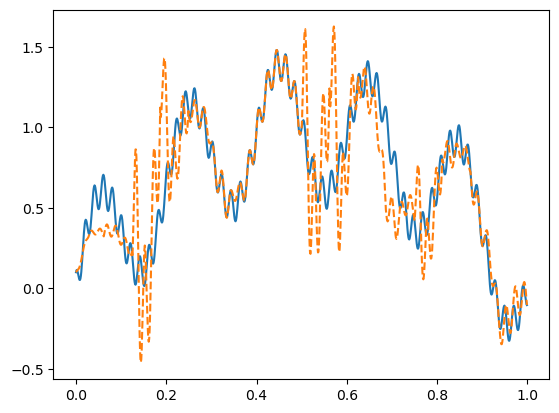

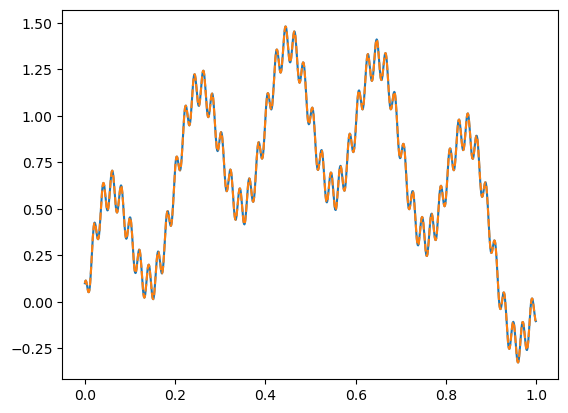

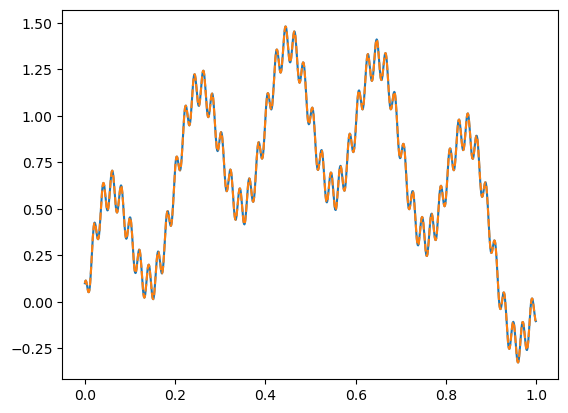

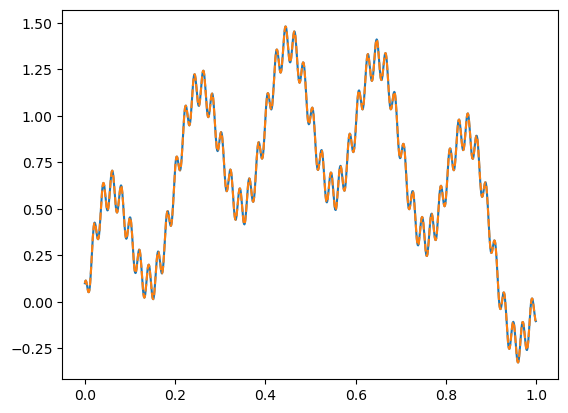

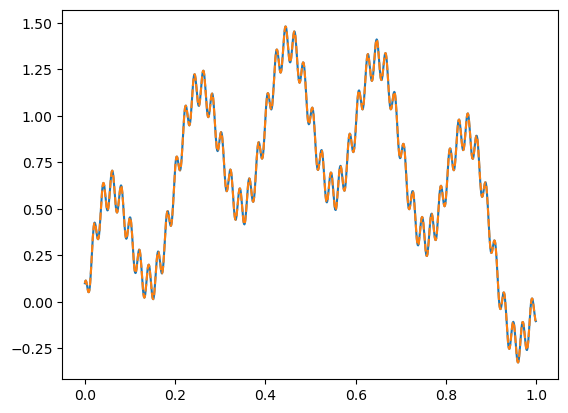

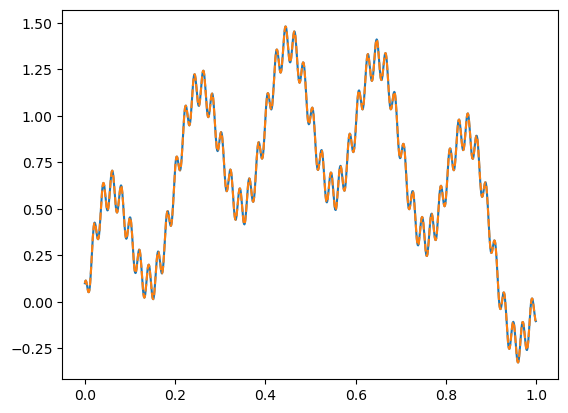

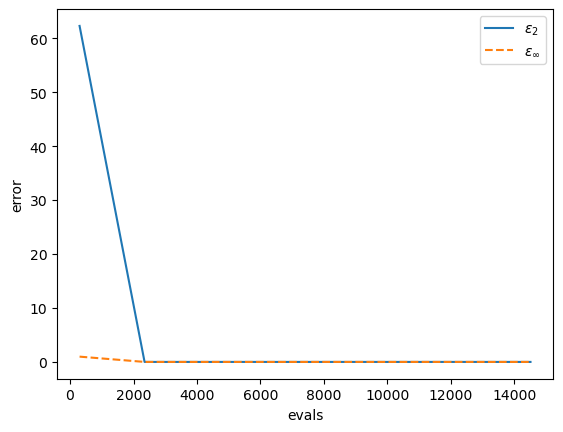

In [8]:
# Example: create a function to interpolate
test_func = lambda x: 0.4 * np.sin(10 * np.pi * x)\
                    + 0.1 * np.cos(99 * np.pi * x)\
                    + 4 * x * (1 - x)

# exact function values
xs = np.linspace(0, 1, 2**10, endpoint=False)
func_vals = test_func(xs)

maxiter = 6

err_max, err_2, evals = eval_error(test_func, xs, maxiter)

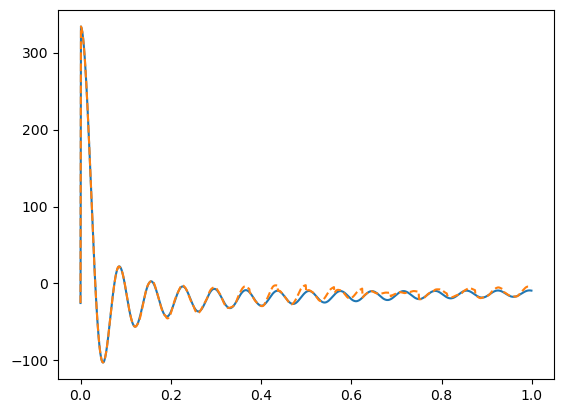

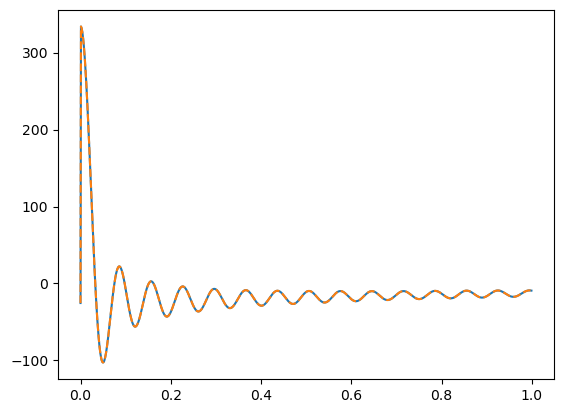

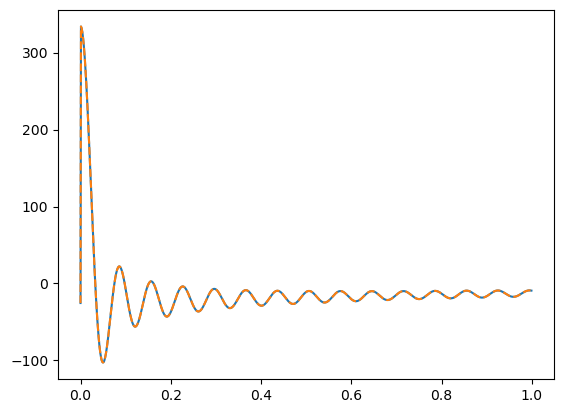

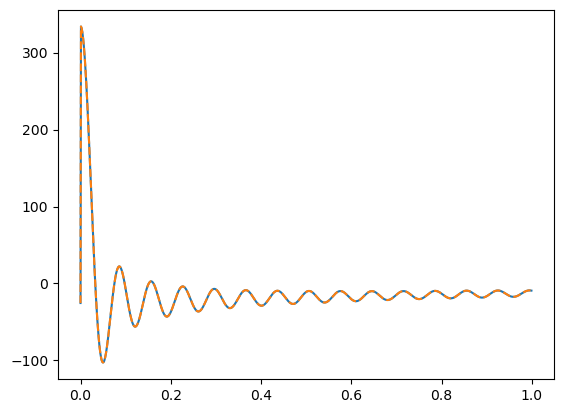

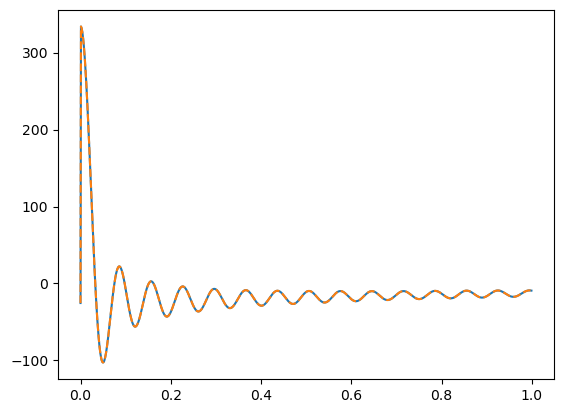

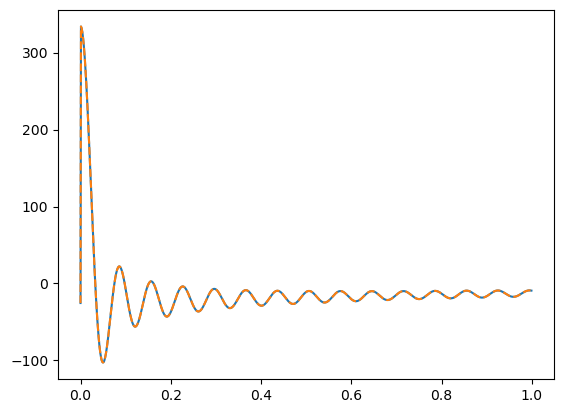

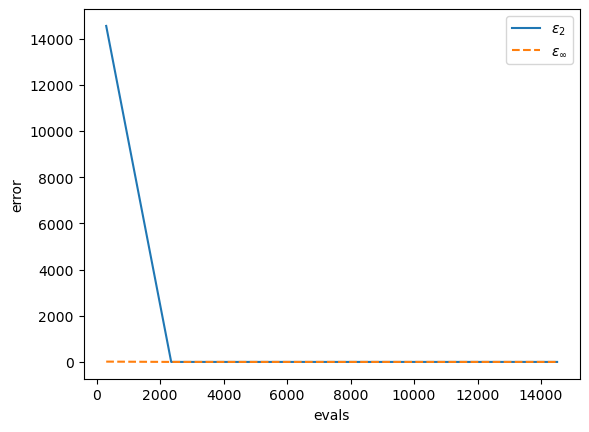

In [14]:
# Example: create a function to interpolate
test_func = lambda x: 0.4 * (x-4)**3\
                    + 0.1 * np.cos(35 * np.pi * x)\
                    + 4 * np.sin(90*x)/(x-0.00000001)\
                    + np.pi*np.log(1/(1+x**2))

# exact function values
xs = np.linspace(0, 1, 2**10, endpoint=False)
func_vals = test_func(xs)

maxiter = 6

err_max, err_2, evals = eval_error(test_func, xs, maxiter)

Sweep: 1.
Sweep: 2.
Sweep: 3.
Sweep: 4.


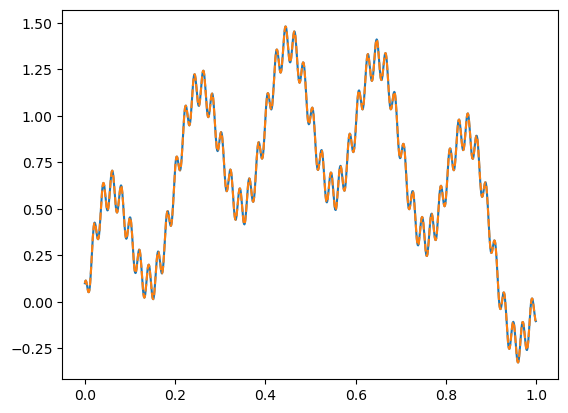

In [ ]:
# Example: create a function to interpolate
test_func = lambda x: 0.4 * np.sin(10 * np.pi * x)\
                    + 0.1 * np.cos(99 * np.pi * x)\
                    + 4 * x * (1 - x)

# exact function values
xs = np.linspace(0, 1, 2**10, endpoint=False)
func_vals = test_func(xs)

# MPS from tensor cross interpolation
func = lambda *args: func_vals.reshape((2,)*10)[*args]
As, _, eval = tensor_cross_interpolation(func,          # function to be interpolated
                                   L=10,          # number of MPS tensors
                                   eps_or_chi=10, # bond dimension
                                   iters=4)       # number of back-and-forth sweeps

# Plot function and interpolation below

# contract full MPS (should only do this for small L <= 20)
func_interp = np.squeeze(As[0])
for A in As[1:]:
    func_interp = np.einsum('ia, ajb -> ijb', func_interp, A)
    func_interp = func_interp.reshape(-1, A.shape[-1])
func_interp = np.squeeze(func_interp)

# plot result
plt.plot(xs, func_vals, '-')
plt.plot(xs, func_interp, '--')
plt.show()